In [ ]:
!pip install torch torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        # Use the correct column names
        img_id = self.annotations.iloc[index]['id_code']  # Column for image IDs
        label = int(self.annotations.iloc[index]['diagnosis'])  # Column for labels

        # Look for the image in the directory
        for folder in os.listdir(self.img_dir):
            img_path = os.path.join(self.img_dir, folder, img_id + ".png")
            if os.path.isfile(img_path):
                image = Image.open(img_path)
                break
        else:
            raise FileNotFoundError(f"Image not found: {img_id}.png in any of the folders")

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to smaller dimensions
    transforms.ToTensor(),
])



# Step 5: Initialize the dataset and dataloader
csv_file_path = '/content/drive/MyDrive/test/dataset/train.csv'  # Update with your file path
img_dir = '/content/drive/MyDrive/test/dataset/colored_images'   # Update with your directory path

dataset = ImageDataset(csv_file=csv_file_path, img_dir=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Step 6: Checking the first batch of images and labels
data_iter = iter(dataloader)
images, labels = next(data_iter)

print(images.shape)  # Should be [batch_size, channels, height, width]
print(labels.shape)  # Should be [batch_size]

torch.Size([32, 3, 128, 128])
torch.Size([32])


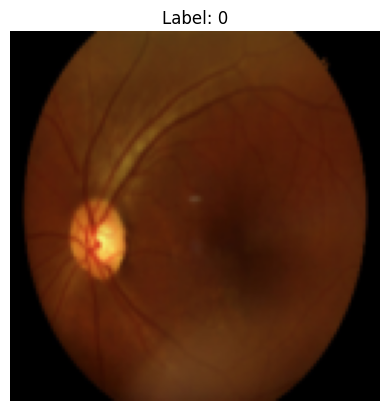

In [ ]:
import matplotlib.pyplot as plt

# Get one batch of images and labels
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Select the first image and its label
image = images[0]
label = labels[0]

# Convert the image tensor back to a NumPy array and transpose it for proper display
image = image.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image)
plt.title(f'Label: {label.item()}')  # Display the label
plt.axis('off')  # Hide axis
plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.Lambda(lambda img: img.convert('RGB')),  # Ensure 3-channel RGB
    transforms.Lambda(lambda img: apply_clahe(img)),  # Apply CLAHE
    transforms.ToTensor(),  # Convert image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize to ImageNet stats
                         std=[0.229, 0.224, 0.225])  # Adjust as per dataset
])


In [ ]:
import cv2
import numpy as np

def apply_clahe(img):
    # Convert PIL image to NumPy array
    img = np.array(img)

    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # Split the LAB channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge the LAB channels and convert back to RGB
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Convert back to PIL image
    return Image.fromarray(img)


In [ ]:
def crop_or_mask(img):
    # Assuming a consistent pattern of irrelevant borders
    img = img.crop((50, 50, 450, 450))  # Adjust crop dimensions based on your dataset
    return img
transforms.Lambda(lambda img: crop_or_mask(img)),


(Lambda(),)

In [ ]:
def reduce_noise(img):
    img = np.array(img)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return Image.fromarray(img)
transforms.Lambda(lambda img: reduce_noise(img)),


(Lambda(),)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Lambda(lambda img: crop_or_mask(img)),
    transforms.Lambda(lambda img: apply_clahe(img)),
    transforms.Lambda(lambda img: reduce_noise(img)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


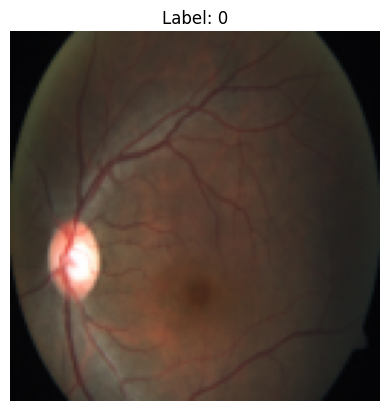

In [ ]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Display first processed image
image = images[0].permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f'Label: {labels[0].item()}')
plt.axis('off')
plt.show()


In [ ]:
# Define the file paths
csv_file_path = '/content/drive/MyDrive/test/dataset/train.csv'  # Path to your CSV file
img_dir = '/content/drive/MyDrive/test/dataset/colored_images'   # Path to your image directory

# Initialize the dataset
dataset = ImageDataset(csv_file=csv_file_path, img_dir=img_dir, transform=transform)


In [ ]:
from torch.utils.data import random_split, DataLoader

# Total dataset size
total_size = len(dataset)

# Define the proportions for splitting
train_size = int(0.7 * total_size)  # 70% for training
val_size = int(0.2 * total_size)    # 20% for validation
test_size = total_size - train_size - val_size  # Remaining 10% for testing

# Split the dataset
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each subset
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)  # Decrease batch size
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)


print(f"Training set: {len(train_loader.dataset)} images")
print(f"Validation set: {len(val_loader.dataset)} images")
print(f"Test set: {len(test_loader.dataset)} images")


Training set: 2563 images
Validation set: 732 images
Test set: 367 images


In [ ]:
# Load the CSV to inspect column names
annotations = pd.read_csv(csv_file_path)
print(annotations.columns)  # Prints the column names in the CSV


Index(['id_code', 'diagnosis'], dtype='object')


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        # Get the image ID and label
        img_id = self.annotations.iloc[index]['id_code']  # Access the id_code column
        label = int(self.annotations.iloc[index]['diagnosis'])  # Access the diagnosis column

        # Construct the image path and load the image
        for folder in os.listdir(self.img_dir):
            img_path = os.path.join(self.img_dir, folder, img_id + ".png")
            if os.path.isfile(img_path):
                image = Image.open(img_path)
                break
        else:
            raise FileNotFoundError(f"Image not found: {img_id}.png in any of the folders")

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Initialize the dataset
dataset = ImageDataset(csv_file=csv_file_path, img_dir=img_dir, transform=transform)

# Check the first sample in the dataset
image, label = dataset[0]
print(f"Image size: {image.size}, Label: {label}")




Image size: <built-in method size of Tensor object at 0x78f38c10a8e0>, Label: 2


In [ ]:
import torch.nn as nn


In [ ]:
class HybridCNN(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)

        # Placeholder for calculating flattened size
        self._flattened_size = None

        # Fully connected layers
        self.fc1 = nn.Linear(1, 256)  # Temporary initialization, will adjust later
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Optional: GRU layer
        self.gru = nn.GRU(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.fc_gru = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional layers with activation and pooling
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Calculate flattened size if not already done
        if self._flattened_size is None:
            self._flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self._flattened_size, 256).to(x.device)  # Dynamically set fc1 size

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x_fc = self.fc3(x)

        # Optional: Process through GRU
        x = x.unsqueeze(1)  # Add a sequence dimension
        gru_out, _ = self.gru(x)
        x_gru = self.fc_gru(gru_out[:, -1, :])  # Use the last GRU output

        # Combine FC and GRU outputs
        x_combined = x_fc + x_gru

        return x_combined


# Define the number of output classes (based on your dataset)
# Fix the column name for the labels
num_classes = len(pd.unique(pd.read_csv(csv_file_path)['diagnosis']))

#num_classes = len(pd.unique(pd.read_csv(csv_file_path)['label']))  # Update for your labels
model = HybridCNN(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print the model structure
print(model)


HybridCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (gru): GRU(128, 64, batch_first=True)
  (fc_gru): Linear(in_features=64, out_features=5, bias=True)
)


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bar

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Use tqdm for progress bar during training
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update progress bar with running loss
        train_loop.set_postfix(loss=(running_loss / total_train))

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_hybrid_cnn.pth')

    # Print epoch stats
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")


Epoch 1/10 [Validation]: 100%|██████████| 92/92 [03:49<00:00,  2.49s/it]



Epoch [1/10]
Train Loss: 0.8271, Train Accuracy: 70.66%
Val Loss: 0.8154, Val Accuracy: 69.95%



Epoch 2/10 [Validation]: 100%|██████████| 92/92 [00:17<00:00,  5.17it/s]



Epoch [2/10]
Train Loss: 0.8153, Train Accuracy: 71.13%
Val Loss: 0.7445, Val Accuracy: 72.95%



Epoch 3/10 [Validation]: 100%|██████████| 92/92 [00:16<00:00,  5.47it/s]



Epoch [3/10]
Train Loss: 0.8242, Train Accuracy: 71.71%
Val Loss: 0.8024, Val Accuracy: 73.22%



Epoch 4/10 [Validation]: 100%|██████████| 92/92 [00:17<00:00,  5.26it/s]



Epoch [4/10]
Train Loss: 0.6993, Train Accuracy: 74.37%
Val Loss: 0.8909, Val Accuracy: 70.90%



Epoch 5/10 [Validation]: 100%|██████████| 92/92 [00:16<00:00,  5.49it/s]



Epoch [5/10]
Train Loss: 0.6655, Train Accuracy: 75.26%
Val Loss: 1.0646, Val Accuracy: 71.86%



Epoch 6/10 [Validation]: 100%|██████████| 92/92 [00:17<00:00,  5.33it/s]



Epoch [6/10]
Train Loss: 0.6099, Train Accuracy: 77.88%
Val Loss: 1.2536, Val Accuracy: 72.68%



Epoch 7/10 [Validation]: 100%|██████████| 92/92 [00:17<00:00,  5.39it/s]



Epoch [7/10]
Train Loss: 0.5328, Train Accuracy: 81.86%
Val Loss: 1.1434, Val Accuracy: 73.36%



Epoch 8/10 [Validation]: 100%|██████████| 92/92 [00:16<00:00,  5.61it/s]



Epoch [8/10]
Train Loss: 0.4388, Train Accuracy: 84.59%
Val Loss: 1.2807, Val Accuracy: 73.22%



Epoch 9/10 [Validation]: 100%|██████████| 92/92 [00:17<00:00,  5.37it/s]



Epoch [9/10]
Train Loss: 0.3225, Train Accuracy: 88.14%
Val Loss: 1.4344, Val Accuracy: 70.90%



Epoch 10/10 [Validation]: 100%|██████████| 92/92 [00:16<00:00,  5.46it/s]


Epoch [10/10]
Train Loss: 0.2705, Train Accuracy: 90.99%
Val Loss: 1.5955, Val Accuracy: 70.77%



In [ ]:
train_accuracies = []  # Initialize before the loop
val_accuracies = []  # Initialize before the loop

for epoch in range(num_epochs):
    # Compute training accuracy
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Append after computing for every epoch

    # Compute validation accuracy
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Append after computing for every epoch


In [ ]:
epochs = range(1, num_epochs + 1)  # Length should be equal to train_accuracies and val_accuracies


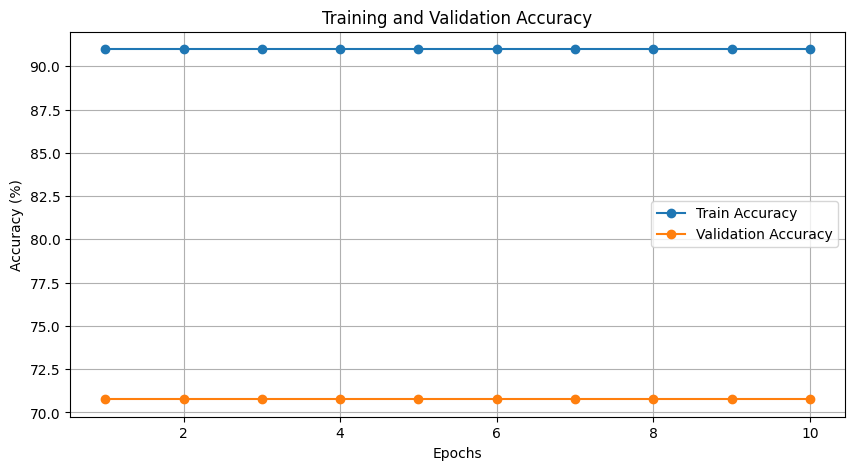

In [ ]:
import matplotlib.pyplot as plt

# Check that all lists have the same length
assert len(epochs) == len(train_accuracies) == len(val_accuracies), "Mismatch in dimensions of epochs and accuracies"

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
print(f"Length of epochs: {len(epochs)}")
print(f"Length of train_accuracies: {len(train_accuracies)}")
print(f"Length of val_accuracies: {len(val_accuracies)}")


Length of epochs: 10
Length of train_accuracies: 10
Length of val_accuracies: 10


In [ ]:
import torch

# Assuming you have defined `test_loader` and `model` earlier, also ensure model is moved to the correct device.
model.load_state_dict(torch.load('best_hybrid_cnn.pth'))  # Load best model
model.eval()  # Set to evaluation mode

# Initialize metrics
test_loss = 0.0
correct_test = 0
total_test = 0

# Use torch.no_grad() to disable gradient calculations for faster inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions and calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

# Compute average loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

# Print results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


<ipython-input-69-30500ecbe24b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_hybrid_cnn.pth'))  # Load best model


Test Loss: 0.7365, Test Accuracy: 71.93%
